# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical,plot_model
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score,ShuffleSplit,train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from skimage import io
from PIL import Image
import scipy.sparse as sparse
import pandas as pd
import random
import h5py
import math
import gc
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
matplotlib.style.use('ggplot')

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# 2. Parameters

In [2]:
dataset_path='./data/faces/ORL_Faces/'

original_edge_length=92
original_edge_width=112

black_area=4

number_samples_for_show=30

minority1=30
minority2=70
minority3=40
majority=90
sampling_times=100
seed_range=np.random.randint(100,size=100)#np.arange(0,100,1)
p_n_estimators=2100

# 3. Import data

## 3.1 Loading data

In [3]:
points = {}

for dirpath, dirnames, filenames in os.walk(dataset_path):
    dirnames.sort()
    filenames.sort()
    for filename in [f for f in filenames if f.endswith(".pgm") and not f[0] == '.']:
        full_path = os.path.join(dirpath, filename)
        filename = full_path.split('/')[-1]
        file_identifier="%s" % (full_path.split('/')[-3])
        #print(file_identifier)
        if file_identifier not in points.keys():
            points[file_identifier] = []
        #image = io.imread(full_path)
        image_=Image.open(full_path).resize((original_edge_length, original_edge_width),Image.ANTIALIAS)
        image=np.asarray(image_)
        points[file_identifier].append(image)

#--------------------------------------------------------------------------------------------------------------------------------
Feature = []
for key in points.keys():
    for image_i in range(len(points[key])):
        Feature.append(np.array(points[key][image_i]))

Features=np.array(Feature)
rn.shuffle(Features)

Features_part1=Features[0:(400-minority1-minority2-minority3)]
Features_part2=Features[(400-minority1-minority2-minority3):(400-minority2-minority3)]
Features_part3=Features[(400-minority2-minority3):(400-minority3)]
Features_part4=Features[(400-minority3):]

Labels=np.r_[np.array([0]*(400-minority1-minority2-minority3)),np.array([1]*minority1),np.array([2]*minority2),np.array([3]*minority3)]

## 3.2 Add noise to data

In [4]:
#--------------------------------------------------------------------------------------------------------------------------------
Collect1_noise_data=[]
for i in np.arange(400-minority1-minority2-minority3):
    Collect1_noise_data_i=np.zeros(Features_part2[1].shape)
    Collect1_noise_data.append(Collect1_noise_data_i)

#--------------------------------------------------------------------------------------------------------------------------------
Collect2_noise_data=[]
for i in np.arange(0,minority1):
    Features_part2_i=Features_part2[i]
    
    noise_data=Features_part2_i
    
    Collect2_noise_data_i=np.zeros(Features_part2[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):
            noise_position_1=19+m+Up_Down_position
            noise_position_2=19+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)

for i in np.arange(0,minority2):
    Features_part3_i=Features_part3[i]
    
    noise_data=Features_part3_i
    
    Collect2_noise_data_i=np.zeros(Features_part3[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):         
            noise_position_1=89+m+Up_Down_position
            noise_position_2=29+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)
    
    
for i in np.arange(0,minority3):
    Features_part4_i=Features_part4[i]
    
    noise_data=Features_part4_i
    
    Collect2_noise_data_i=np.zeros(Features_part4[1].shape)
    
    Up_Down_position=random.randint(-3,3)
    Left_Right_position=random.randint(-3,3)
    #Up_Down_position=0
    #Left_Right_position=0
    
    for m in np.arange(black_area):
        for n in np.arange(black_area):
            noise_position_1=19+m+Up_Down_position
            noise_position_2=19+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1   
            
            noise_position_1=89+m+Up_Down_position
            noise_position_2=29+n+Left_Right_position
            
            noise_data[noise_position_1,noise_position_2]=0.1
            Collect2_noise_data_i[noise_position_1,noise_position_2]=0.1
            
    Collect2_noise_data.append(Collect2_noise_data_i)
    
#--------------------------------------------------------------------------------------------------------------------------------
Array_Feature = []
for i in np.arange(Features.shape[0]):
    Array_Feature.append(Features[i].flatten())

#--------------------------------------------------------------------------------------------------------------------------------
Collect_noise_data=np.array(Collect1_noise_data+Collect2_noise_data)
print('Shape of Collect_noise_data',Collect_noise_data.shape)

Shape of Collect_noise_data (400, 112, 92)


In [5]:
rand_indices = np.random.permutation(400)

Array_Feature_=np.array(Array_Feature)[rand_indices]
Labels_=np.array(Labels)[rand_indices]

## 3.3 The number of samples for different classes

In [6]:
for i in np.arange(4):
    print(i,":",np.sum(Labels_==i))

0 : 260
1 : 30
2 : 70
3 : 40


## 3.4 Do undersampling and generate multiple sample subsets

In [7]:
Samples_list=[]
Labels_for_Samples_list=[]
for time_i in np.arange(sampling_times):
    seed_i=time_i
    rus=RandomUnderSampler(sampling_strategy={0: majority,1:minority1,2:minority2,3:minority3},random_state=time_i,replacement=True)
    Samples_,Labels_for_Samples_=rus.fit_sample(Array_Feature_,Labels_)
    Samples_list.append(Samples_)
    Labels_for_Samples_list.append(Labels_for_Samples_)

## 3.5 Split training and testing samples

In [8]:
X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]

for time_i in np.arange(sampling_times):
    Samples_list_i_=Samples_list[time_i]
    Labels_for_Samples_i_=Labels_for_Samples_list[time_i]
    rand_indices = np.random.permutation(majority+minority1+minority2+minority3)
    Samples_list_i=Samples_list_i_[rand_indices]
    Labels_for_Samples_i=Labels_for_Samples_i_[rand_indices]
    
    X_train_i,X_test_i, y_train_i, y_test_i =train_test_split(Samples_list_i,Labels_for_Samples_i,test_size=0.3, random_state=seed)

    print('Shape of X_train_i: ' + str(X_train_i.shape))
    print('Shape of y_train_i: ' + str(y_train_i.shape))
    print('Shape of X_test_i: ' + str(X_test_i.shape))
    print('Shape of y_test_i: ' + str(y_test_i.shape))
    
    X_train_list.append(X_train_i)
    X_test_list.append(X_test_i)
    y_train_list.append(y_train_i)
    y_test_list.append(y_test_i)
    
    print("\n======================================================\n\n")

Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_train_i: (161,)
Shape of X_test_i: (69, 10304)
Shape of y_test_i: (69,)



Shape of X_train_i: (161, 10304)
Shape of y_trai

## 3.6 Display training and testing samples

./Defined/Functions.py:71: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(p_pad,p_w_pad, p_h_pad)


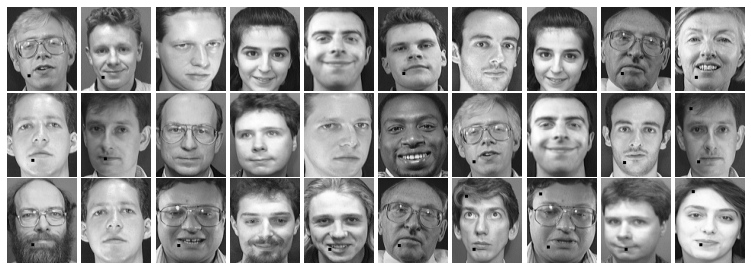

In [9]:
F.show_data_figures(np.array(X_train_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [10]:
y_train_list[0][0:number_samples_for_show]

array([2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 3, 2, 0,
       2, 0, 2, 2, 3, 3, 2, 3])

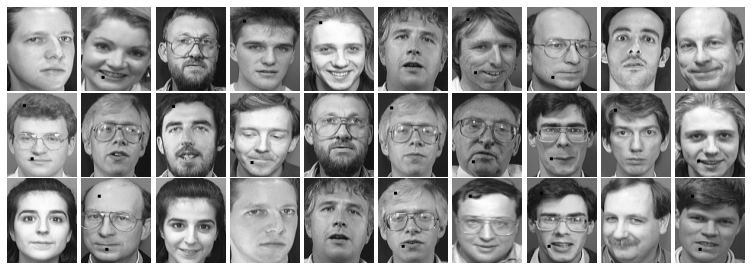

In [11]:
F.show_data_figures(np.array(X_train_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [12]:
y_train_list[1][0:number_samples_for_show]

array([0, 2, 0, 1, 1, 0, 3, 2, 0, 0, 3, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 3,
       0, 0, 0, 3, 1, 3, 0, 3])

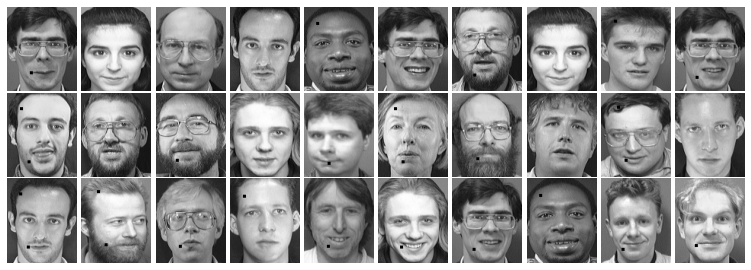

In [13]:
F.show_data_figures(np.array(X_test_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [14]:
y_test_list[0][0:number_samples_for_show]

array([2, 0, 0, 0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 0, 2, 3, 2, 0, 3, 0, 3, 3,
       2, 1, 2, 2, 2, 1, 2, 2])

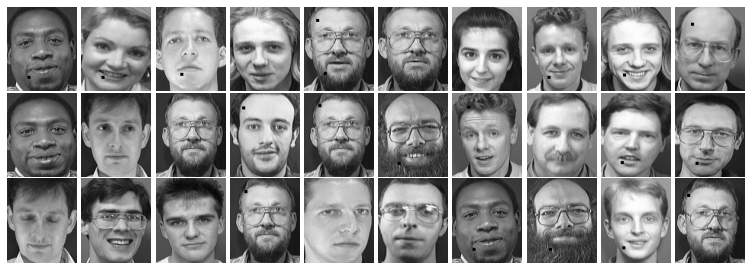

In [15]:
F.show_data_figures(np.array(X_test_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=-1)

In [16]:
y_train_list[1][0:number_samples_for_show]

array([0, 2, 0, 1, 1, 0, 3, 2, 0, 0, 3, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 3,
       0, 0, 0, 3, 1, 3, 0, 3])

# 4 Analysis

## 4.1 Improt predicated results

In [17]:
path_predicated_results="./RF_results/predicated_results_sl3_2M_4L.csv"
predicated_results=pd.read_csv(path_predicated_results, sep='delimiter', header=None)
class_names=["Clean fact","N1-Clean fact","N2-Clean fact","N12-Clean fact"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


## 4.2 Average accuarcy and confusion matrix

In [18]:
time_i=int(predicated_results.shape[0]/(4*len(seed_range)))
print("The number of samplings: ",time_i)

Acc_train_ave_collect=[]
Acc_test_ave_collect=[]
conf_martix_ave_collect=[]
report_matrix_ave_collect=[]

for time_i in np.arange(time_i):
    print("Sampling "+str(time_i+1)+"----------------------------------------------------------------------------------\n")
    
    Acc_train_list=[]
    Acc_test_list=[]

    conf_martix=[]
    report_matrix=[]

    for pred_i in np.arange(len(seed_range)*time_i,len(seed_range)*(time_i+1)):
    
        Acc_train=np.array(predicated_results)[4*pred_i]
        Acc_test=np.array(predicated_results)[4*pred_i+1]
        p_y_pred=np.array(predicated_results)[4*pred_i+2]
        p_y_test=np.array(predicated_results)[4*pred_i+3]
        
        Acc_train_list.append(Acc_train)
        Acc_test_list.append(Acc_test)
    
        pred_set=np.array(p_y_pred[0].split(",")).astype(float)
        truth_set=np.array(p_y_test[0].split(",")).astype(float)

        conf_martix_i = np.array(confusion_matrix(truth_set, pred_set))
        conf_martix.append(conf_martix_i)

        report = classification_report(truth_set, pred_set)
        report_matrix_i=[]
        report_matrix_i.append(np.array(report.split('\n')[2].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[3].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[4].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[5].split()[1:]).astype(float))
        report_matrix_i.append(np.array(['nan','nan']+report.split('\n')[7].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[8].split()[2:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[9].split()[2:]).astype(float))

        report_matrix.append(np.array(report_matrix_i))
    
    # Accuarcy---------------------------------------------------------------------------------------------------------
    Acc_train_ave=np.average(np.array(Acc_train_list).astype(float))
    Acc_test_ave=np.average(np.array(Acc_test_list).astype(float))
    print("Acc_train_ave: ",Acc_train_ave)
    print("Acc_test_ave: ",Acc_test_ave)
    print('\n')

    Acc_train_ave_collect.append(Acc_train_ave)
    Acc_test_ave_collect.append(Acc_test_ave)
    
    # Confusion martix---------------------------------------------------------------------------------------------------------
    conf_martix_ave=np.average(conf_martix,axis=0)
    print("Confusion martix: ",conf_martix_ave)
    print('\n')

    conf_martix_ave_collect.append(conf_martix_ave)

    # Report---------------------------------------------------------------------------------------------------------
    report_matrix_ave=np.average(report_matrix,axis=0)
    Title=np.array(['Classes']+report.split('\n')[0].split()).reshape(1,5)
    report_matrix_ave_=np.c_[np.array(class_names+['accuracy','macro avg','weighted avg']),np.round(report_matrix_ave,decimals=4).astype(str)]

    report_matrix_ave_mergetitle=np.r_[np.array(Title),report_matrix_ave_]

    for i in report_matrix_ave_mergetitle:
        print('\t\t'.join(i))
        
    report_matrix_ave_collect.append(report_matrix_ave)
    
    print("\n\n\n")

The number of samplings:  100
Sampling 1----------------------------------------------------------------------------------

Acc_train_ave:  1.0
Acc_test_ave:  0.7475362318840578


Confusion martix:  [[20.    1.    3.    0.  ]
 [ 2.    4.    3.86  0.14]
 [ 3.    0.42 18.58  2.  ]
 [ 1.    0.    1.    9.  ]]


Classes		precision		recall		f1-score		support
Clean fact		0.77		0.83		0.8		24.0
N1-Clean fact		0.7454		0.4		0.5174		10.0
N2-Clean fact		0.7		0.7732		0.7395		24.0
N12-Clean fact		0.8109		0.82		0.8151		11.0
accuracy		nan		nan		0.7458		69.0
macro avg		0.7561		0.7058		0.7151		69.0
weighted avg		0.7516		0.7458		0.7415		69.0




Sampling 2----------------------------------------------------------------------------------

Acc_train_ave:  1.0
Acc_test_ave:  0.5798550724637682


Confusion martix:  [[20.    0.07  5.93  0.  ]
 [ 7.    4.    0.    1.  ]
 [ 4.99  3.   13.01  3.  ]
 [ 3.    0.    1.    3.  ]]


Classes		precision		recall		f1-score		support
Clean fact		0.5702		0.77		0.6601		26.0


In [19]:
final_ave_ConfusionMatrix=(np.round(np.average(conf_martix_ave_collect,axis=0))).astype(int)
print("Confusion Matrix\n",final_ave_ConfusionMatrix)

Confusion Matrix
 [[22  1  3  1]
 [ 2  5  2  0]
 [ 5  1 15  1]
 [ 2  0  3  6]]


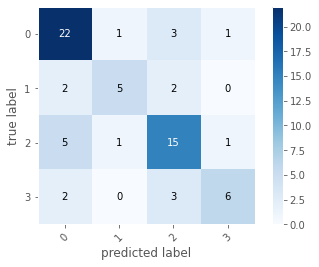

In [20]:
class_names = ['0', '1', '2', '3']
fig, ax = plot_confusion_matrix(conf_mat=final_ave_ConfusionMatrix,
                                colorbar=True,
                                #show_absolute=False,
                                #show_normed=True,
                                class_names=class_names)
plt.show()

In [21]:
final_ave_ReportMatrix=np.round (np.average(report_matrix_ave_collect,axis=0),decimals=3)
print("Report Matrix\n",final_ave_ReportMatrix)

Report Matrix
 [[ 0.701  0.818  0.749 26.73 ]
 [ 0.739  0.534  0.595  9.02 ]
 [ 0.661  0.7    0.671 21.39 ]
 [ 0.764  0.54   0.614 11.86 ]
 [   nan    nan  0.69  69.   ]
 [ 0.716  0.647  0.657 69.   ]
 [ 0.713  0.69   0.682 69.   ]]


## 4.3 Improt preprocessed results (importance)

In [22]:
path_preprocessed_results="./RF_results/preprocessed_results_sl3_2M_4L.csv"
preprocessed_results=np.array(pd.read_csv(path_preprocessed_results,header=None))
preprocessed_results.shape

(100, 10304)

## 4.4 Compute the important features for each undersampling

In [23]:
groups=4
top_select=80

In [24]:
print("preprocessed_results.shape[0]",preprocessed_results.shape,"\n")

group_importance=[]
selected_feature_indices=[]

memebers=int(preprocessed_results.shape[0]/float(groups))
for group_i in np.arange(groups):
    group_importance_i=np.sum(preprocessed_results[group_i*memebers:(group_i+1)*memebers,:],axis=0)
    indices_i=np.argsort(group_importance_i)[::-1][0:top_select]
    
    group_importance.append(group_importance_i)
    selected_feature_indices.append(indices_i)

preprocessed_results.shape[0] (100, 10304) 



The number of group 0


./Defined/Functions.py:107: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(p_pad,p_w_pad, p_h_pad)


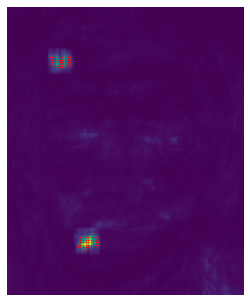

The number of group 1


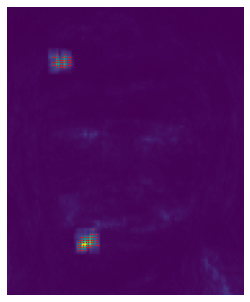

The number of group 2


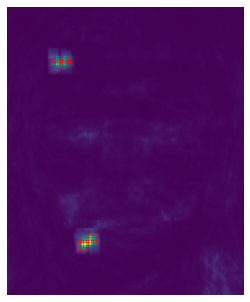

The number of group 3


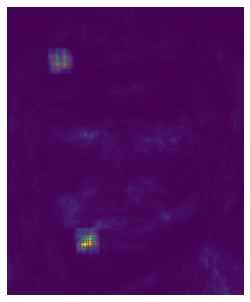

In [25]:
for group_i in np.arange(groups):
    print("The number of group",group_i)
    F.draw_with_importance(group_importance[group_i],original_edge_width,original_edge_length,top_select)

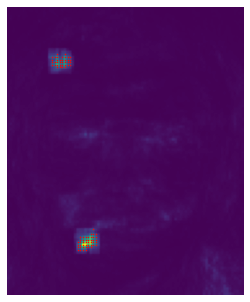

In [26]:
F.draw_with_importance(np.mean(group_importance,axis=0),original_edge_width,original_edge_length,top_select)

## 4.5 Compute the common important features from each undersampling

In [27]:
interect_indices=F.intersect_2Dlist(selected_feature_indices)
background=np.zeros(original_edge_length*original_edge_width)
background[F.intersect_2Dlist(selected_feature_indices)]=group_importance[0][interect_indices]

The number of group 0


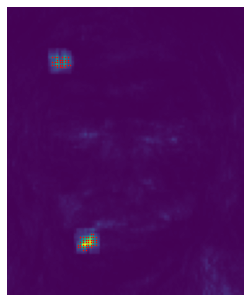

The number of group 1


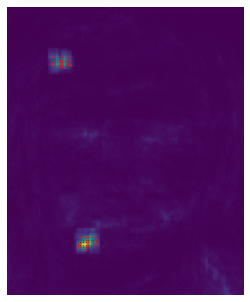

The number of group 2


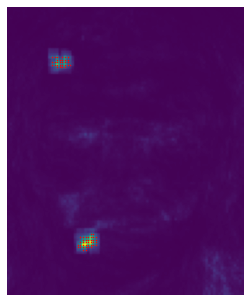

The number of group 3


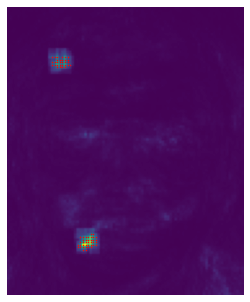

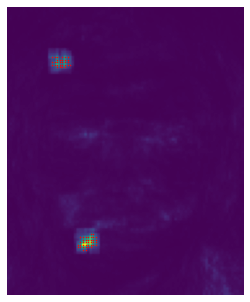

In [28]:
common_feature_catch=[]
for interect_indices_i in interect_indices:
    common_feature_catch.append([int(interect_indices_i/(original_edge_length)),interect_indices_i%(original_edge_length)])

for group_i in np.arange(groups):
    print("The number of group",group_i)
    F.show_one_figure_with_keyfeature(group_importance[group_i],common_feature_catch,original_edge_width,original_edge_length)
    
F.show_one_figure_with_keyfeature(np.average(np.array(group_importance),axis=0),common_feature_catch,original_edge_width,original_edge_length)

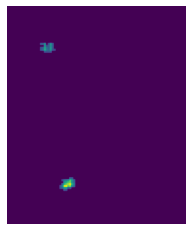

In [29]:
plt.imshow(background.reshape(original_edge_width,original_edge_length))
plt.axis('off')
plt.show()

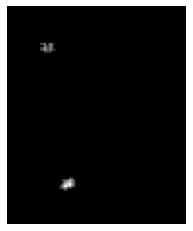

In [30]:
plt.imshow(background.reshape(original_edge_width,original_edge_length),plt.cm.gray)
plt.axis('off')
plt.show()

## 4.6 Show the common important features from each undersampling and comparing with the original key features

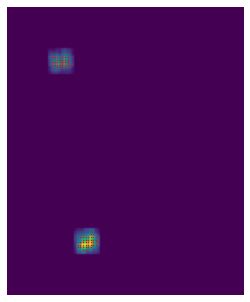

In [31]:
F.show_one_figure_with_keyfeature(Collect_noise_data.sum(axis=0),common_feature_catch,original_edge_width,original_edge_length)

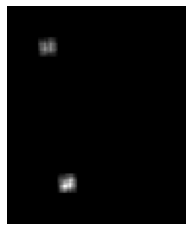

In [32]:
plt.imshow(Collect_noise_data.sum(axis=0),plt.cm.gray)
plt.axis('off')
plt.show()

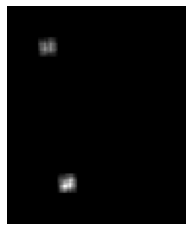

In [33]:
plt.imshow(Collect_noise_data.sum(axis=0),plt.cm.gray)
plt.axis('off')
plt.show()